In [1]:
from AffineFace import Image
import numpy as np
import matplotlib.pyplot as plt
import dlib
from urllib.request import urlretrieve
import bz2
from zipfile import ZipFile
from io import BytesIO

In [2]:
url = 'http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2'
filepath  = urlretrieve(url)[0]
data = bz2.BZ2File(filepath).read()
with open(filepath, 'wb') as f:
    f.write(data)

predictor = dlib.shape_predictor(filepath)
detector = dlib.get_frontal_face_detector()

In [3]:
face = Image('face.png')

face_array = np.array(face.im)
frame = detector(face_array)[0]
sp = predictor(face_array, frame)

landmarks = np.array([[sp.part(i).x, sp.part(i).y] for i in range(5)])

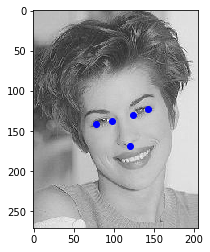

In [4]:
plt.scatter(landmarks[:,0], landmarks[:,1], color='blue')
plt.imshow(face.im, cmap='gray')

In [5]:
eye1 = np.mean(landmarks[0:2], axis=0)
eye2 = np.mean(landmarks[2:4], axis=0)
mid_eye = np.mean([eye1, eye2], axis=0)
nose = landmarks[-1]

landmarks = np.stack([eye1, eye2, mid_eye, nose])

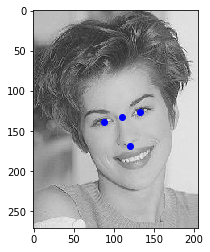

In [6]:
plt.scatter(landmarks[:,0], landmarks[:,1], color='blue')
plt.imshow(face.im, cmap='gray')

In [7]:
similarity_im, similarity_matrix = face.align(
    (eye2, eye1), eyes_distance=100, size=(200, 250), 
    x_offset=50, y_offset=50)

In [8]:
warp = lambda mat, x: mat.dot(np.append(x, 1).reshape(-1, 1))[:2].ravel()
similarity_landmarks = np.array([warp(similarity_matrix, landmark) for landmark in landmarks])

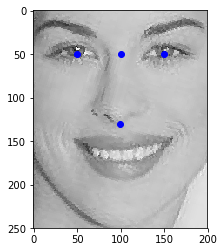

In [9]:
plt.scatter(similarity_landmarks[:,0], similarity_landmarks[:,1], color='blue')
plt.imshow(similarity_im, cmap='gray')

In [10]:
affine_im, affine_matrix = face.align(
    (eye2, eye1), eyes_distance=100, size=(200, 250), 
    x_offset=50, y_offset=50, 
    aux=nose, aux_distance=100)

affine_landmarks = np.array([warp(affine_matrix, landmark) for landmark in landmarks])

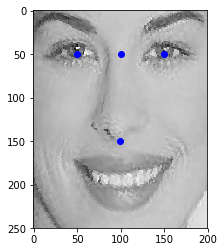

In [11]:
plt.scatter(affine_landmarks[:,0], affine_landmarks[:,1], color='blue')
plt.imshow(affine_im, cmap='gray')

In [12]:
url_list = [
    'https://fei.edu.br/~cet/frontalimages_manuallyaligned_part1.zip',
    'https://fei.edu.br/~cet/frontalimages_manuallyaligned_part2.zip',
]
archive = [ZipFile(urlretrieve(url)[0], 'r') for url in url_list]
images = [image for zipfile in archive for image in zipfile.namelist()]

In [13]:
original_faces = []
original_faces_array = []
landmarks_array = []

for image in images:
    try:
        face = Image(BytesIO(archive[0].read(image)))
    except:
        face = Image(BytesIO(archive[1].read(image)))
    
    original_faces.append(face)
    
    face_array = np.array(face.im)
    frame = detector(face_array)[0]
    sp = predictor(face_array, frame)
    
    original_faces_array.append(face_array)
    landmarks_array.append(np.array([[sp.part(i).x, sp.part(i).y] for i in range(5)]))

original_faces_array = np.array(original_faces_array)
landmarks_array = np.array(landmarks_array)

In [14]:
mean_face = np.mean(original_faces_array, axis=0).astype(np.uint8)
mean_landmarks = np.mean(landmarks_array, axis = 0)

mean_eye1 = np.mean(mean_landmarks[0:2], axis=0)
mean_eye2 = np.mean(mean_landmarks[2:4], axis=0)
mean_mid_eye = np.mean([mean_eye1, mean_eye2], axis=0)
mean_nose = mean_landmarks[-1]

mean_landmarks = np.stack([mean_eye1, mean_eye2, mean_mid_eye, mean_nose])

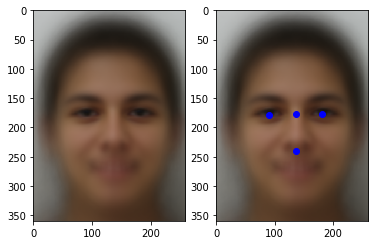

In [15]:
plt.subplot(1, 2, 1)
plt.imshow(mean_face)

plt.subplot(1, 2, 2)
plt.scatter(mean_landmarks[:,0], mean_landmarks[:,1], color='blue')
plt.imshow(mean_face)

In [16]:
eyes_distance = mean_eye1[0] - mean_eye2[0]
aux_distance = mean_nose[1] - mean_mid_eye[1]
x_offset = mean_eye2[0]
y_offset = mean_eye2[1]

print('Eyes Distance: %d pixels' %eyes_distance)
print('Aux Distance: %d pixels' %aux_distance)
print('X Offset: %d pixels' %x_offset)
print('Y Offset: %d pixels' %y_offset)

Eyes Distance: 89 pixels
Aux Distance: 63 pixels
X Offset: 91 pixels
Y Offset: 178 pixels


In [17]:
similarity_faces = []
affine_faces = []

for face, landmarks in zip(original_faces, landmarks_array):
    eye1 = np.mean(landmarks[0:2], axis=0)
    eye2 = np.mean(landmarks[2:4], axis=0)
    nose = landmarks[-1]
    
    similarity_im, similarity_matrix = face.align(
        (eye2, eye1), eyes_distance=eyes_distance,
        x_offset=x_offset, y_offset=y_offset)
    
    affine_im, affine_matrix = face.align(
        (eye2, eye1), eyes_distance=eyes_distance,
        x_offset=x_offset, y_offset=y_offset,
        aux=nose, aux_distance=aux_distance)
    
    similarity_faces.append(np.array(similarity_im))
    affine_faces.append(np.array(affine_im))

similarity_faces = np.array(similarity_faces)
affine_faces = np.array(affine_faces)

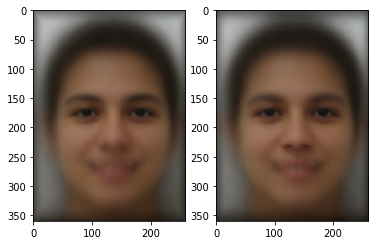

In [18]:
plt.subplot(1, 2, 1)
plt.imshow(np.mean(similarity_faces, axis=0).astype(np.uint8))

plt.subplot(1, 2, 2)
plt.imshow(np.mean(affine_faces, axis=0).astype(np.uint8))

In [19]:
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
filepath  = urlretrieve(url)[0]
data = bz2.BZ2File(filepath).read()
with open(filepath, 'wb') as f:
    f.write(data)

predictor = dlib.shape_predictor(filepath)

In [20]:
landmarks_array = []
for face_array in original_faces_array:   
    frame = detector(face_array)[0]
    sp = predictor(face_array, frame)
    landmarks_array.append(np.array([[sp.part(i).x, sp.part(i).y] for i in range(68)]))

landmarks_array = np.array(landmarks_array)

In [21]:
mean_landmarks = np.mean(landmarks_array, axis = 0)

mean_eye1 = np.mean(mean_landmarks[[37,38,40,41]], axis=0)
mean_eye2 = np.mean(mean_landmarks[[43,44,46,47]], axis=0)
mean_mid_eye = np.mean([mean_eye1, mean_eye2], axis=0)
mean_mouth = np.mean(mean_landmarks[[61,62,63,65,66,67]], axis=0)

mean_landmarks = np.stack([mean_eye1, mean_eye2, mean_mid_eye, mean_mouth])

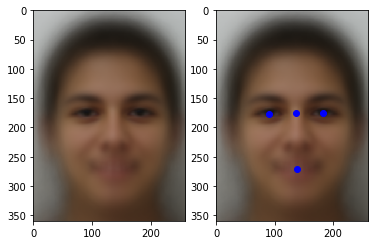

In [22]:
plt.subplot(1, 2, 1)
plt.imshow(mean_face)

plt.subplot(1, 2, 2)
plt.scatter(mean_landmarks[:,0], mean_landmarks[:,1], color='blue')
plt.imshow(mean_face)

In [23]:
eyes_distance = mean_eye2[0] - mean_eye1[0]
aux_distance = mean_mouth[1] - mean_mid_eye[1]
x_offset = mean_eye1[0]
y_offset = mean_eye1[1]

print('Eyes Distance: %d pixels' %eyes_distance)
print('Aux Distance: %d pixels' %aux_distance)
print('X Offset: %d pixels' %x_offset)
print('Y Offset: %d pixels' %y_offset)

Eyes Distance: 90 pixels
Aux Distance: 94 pixels
X Offset: 91 pixels
Y Offset: 176 pixels


In [24]:
affine_faces = []

for face, landmarks in zip(original_faces, landmarks_array):
    eye1 = np.mean(landmarks[[37,38,40,41]], axis=0)
    eye2 = np.mean(landmarks[[43,44,46,47]], axis=0)
    mouth = np.mean(landmarks[[61,62,63,65,66,67]], axis=0)
    
    affine_im, affine_matrix = face.align(
        (eye1, eye2), eyes_distance=eyes_distance,
        x_offset=x_offset, y_offset=y_offset,
        aux=mouth, aux_distance=aux_distance)
    
    affine_faces.append(np.array(affine_im))

affine_faces = np.array(affine_faces)

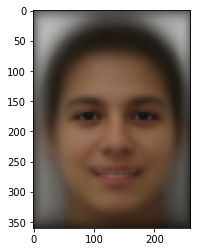

In [25]:
plt.imshow(np.mean(affine_faces, axis=0).astype(np.uint8))